In [1]:
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [75]:
import matplotlib.pyplot as plt

In [66]:
from scipy.interpolate import PchipInterpolator

In [51]:
import pandas as pd
import numpy as np
import sys; sys.path.append('../slip_rate_tools/')
import slip_rate_tools as srt

offset_df = pd.read_csv('../test_data/offsets.csv')
offset_df['offset_m'] = offset_df.offset_in * 200.

t1 = offset_df[offset_df.unit == 'T1']
qa = offset_df[offset_df.unit == 'Qa']
qao = offset_df[offset_df.unit == 'Qao']

#qao['offset_m'] *= 1.5

t1_age = {'mean': 24., 'sd':8.}
qa_age = {'mean': 50., 'sd':20.}
qao_age = {'mean':100., 'sd':32.}

T1 = srt.OffsetMarker(age_mean=t1_age['mean'], age_sd=t1_age['sd'],
                      offset_vals=t1.offset_m, offset_probs=t1.rel_prob)

Qa = srt.OffsetMarker(age_mean=qa_age['mean'], age_sd=qa_age['sd'],
                      offset_vals=qa.offset_m, offset_probs=qa.rel_prob)

Qao = srt.OffsetMarker(age_mean=qao_age['mean'], age_sd=qao_age['sd'],
                      offset_vals=qao.offset_m, offset_probs=qao.rel_prob)


In [23]:
offset_df

,unit,offset_in,rel_prob,offset_m
0,T1,0.0000,0.00,0.00
1,T1,0.0491,3.00,9.82
2,T1,0.0961,7.00,19.22
3,T1,0.1107,10.00,22.14
4,T1,0.2081,7.50,41.62
5,T1,0.3747,1.50,74.94
6,T1,0.4202,0.00,84.04
7,Qa,0.0963,0.00,19.26
8,Qa,0.2133,3.00,42.66
9,Qa,0.2777,8.50,55.54


In [25]:
qao

,unit,offset_in,rel_prob,offset_m
15,Qao,0.1892,0.00,56.76
16,Qao,0.2966,1.00,88.98
17,Qao,0.4137,8.00,124.11
18,Qao,0.5210,10.00,156.30
19,Qao,0.5979,8.00,179.37
20,Qao,0.7442,4.00,223.26
21,Qao,0.8507,2.50,255.21
22,Qao,1.9000,1.25,570.00
23,Qao,2.2000,1.00,660.00
24,Qao,2.3500,0.00,705.00


In [11]:
T1.sample(10)

(array([ 16.31694064,  36.73410475,  26.81866518,  18.7844328 ,
         14.70398688,   5.73569941,  18.69811823,  21.80703614,
         35.00612989,  22.47813497]),
 array([ 21.42646304,  33.52158302,  21.31053705,  14.04337784,
          9.26645959,  19.36819734,  24.10638945,  13.46958588,
         65.11186479,  37.60305611]))

In [52]:
def make_age_offset_arrays(offset_list, n, check_increasing=False, zero_offset_age=0.):
    
    #np.random.seed(69)
    
    
    age_array = np.zeros((n, len(offset_list)+1))
    off_array = np.zeros((n, len(offset_list)+1))
    
    age_array[:,0] = zero_offset_age
    
    for i, off_mark in enumerate(offset_list):
        col = i+1
        age_array[:,col], off_array[:,col] = off_mark.sample(n)
        
    if check_increasing == True:
        
        def make_inc_bool(age_array, off_array, n):
        
            inc_bool = np.ones((age_array.shape[0]), dtype=int)
            for row in range(n):
                age_inc = srt.check_increasing(age_array[row,:])
                off_inc = srt.check_increasing(off_array[row,:])
                
                if not (age_inc and off_inc):
                    inc_bool[row] = 0
                    
            #print('ic',inc_bool.sum())
            inc_bool = np.array(inc_bool, dtype=bool)
                
            return inc_bool
    
        inc_bool = make_inc_bool(age_array, off_array, n)
                    
        age_array = age_array[inc_bool, :]
        off_array = off_array[inc_bool, :]
        
        while age_array.shape[0] < n:
            
            next_age_array, next_off_array = make_age_offset_arrays(offset_list, n, 
                                                                    check_increasing=False,
                                                                    zero_offset_age=zero_offset_age)
            
            next_inc_bool = make_inc_bool(next_age_array, next_off_array, n)
            
            next_age_array = next_age_array[next_inc_bool, :]
            next_off_array = next_off_array[next_inc_bool, :]
           
            off_array = np.vstack([off_array, next_off_array])
            age_array = np.vstack([age_array, next_age_array])
            
            #print(age_array.shape[0])
            
    return age_array[:n,:], off_array[:n,:]
    #    return age_array, off_array, inc_bool
    #
    #else:
    #    return age_array, off_array
    
    

In [54]:
%%timeit
make_age_offset_arrays([T1, Qa, Qao], 1000)

100 loops, best of 3: 10.1 ms per loop


In [57]:
%%timeit
make_age_offset_arrays([T1, Qa, Qao], 50000, check_increasing=True)

1 loops, best of 3: 27.7 s per loop


In [116]:
@jit
def jit_age_offset_arrays(offset_list, n):
    check_increasing=True
    zero_offset_age=0.
    #np.random.seed(69)
    
    
    age_array = np.zeros((n, len(offset_list)+1))
    off_array = np.zeros((n, len(offset_list)+1))
    
    age_array[:,0] = zero_offset_age
    
    for i, off_mark in enumerate(offset_list):
        col = i+1
        age_array[:,col], off_array[:,col] = off_mark.sample(n)
        
    if check_increasing == True:
    
        inc_bool = make_inc_bool(age_array, off_array, n)
                    
        age_array = age_array[inc_bool, :]
        off_array = off_array[inc_bool, :]
        
        while age_array.shape[0] < n:
            
            next_age_array, next_off_array = make_age_offset_arrays(offset_list, n, 
                                                                    check_increasing=False,
                                                                    zero_offset_age=zero_offset_age)
            
            next_inc_bool = make_inc_bool(next_age_array, next_off_array, n)
            
            next_age_array = next_age_array[next_inc_bool, :]
            next_off_array = next_off_array[next_inc_bool, :]
           
            off_array = np.vstack([off_array, next_off_array])
            age_array = np.vstack([age_array, next_age_array])
            
            #print(age_array.shape[0])
            
    return age_array[:n,:], off_array[:n,:]

@jit
def make_inc_bool(age_array, off_array, n):
        
    inc_bool = np.ones((age_array.shape[0]), dtype=int)
    for row in range(n):
        age_inc = srt.check_increasing(age_array[row,:])
        off_inc = srt.check_increasing(off_array[row,:])
                
        if not (age_inc and off_inc):
            inc_bool[row] = 0
                    
            #print('ic',inc_bool.sum())
    inc_bool = np.array(inc_bool, dtype=bool)
                
    return inc_bool

In [119]:
%%timeit
jit_age_offset_arrays([T1, Qa, Qao], 5000)

1 loops, best of 3: 2.84 s per loop


In [56]:
age_arr, off_arr = make_age_offset_arrays([T1, Qa, Qao], 1000, check_increasing=True)

In [60]:
times = np.linspace(0, 200, num=1000)

In [70]:
%%timeit

sh1 = [srt.sample_slip_history(age_arr[row,:], off_arr[row,:], times) for row in range(1000)]

1 loops, best of 3: 638 ms per loop


In [65]:
sh1[0] - sh1[1]

ValueError: operands could not be broadcast together with shapes (579,) (407,) 

In [83]:
def interp(age_array, off_array, time_array, extrapolate=False):
    sh_int = PchipInterpolator(age_array, off_array, extrapolate=extrapolate)
    
    return sh_int(time_array, 0, extrapolate)

In [92]:
#%%timeit

sh2 = [interp(age_arr[row,:], off_arr[row,:], times) for row in range(1000)]

In [93]:
arr = np.vstack(sh2)

In [94]:
arr.shape

(1000, 1000)

In [95]:
np.isnan(arr).sum()

474566

In [100]:
arr0 = arr.copy()
arr0[np.isnan(arr0)] = 0.

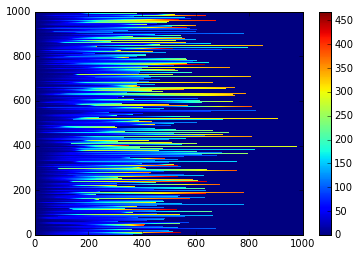

In [101]:
plt.pcolormesh(arr0)

plt.colorbar()

plt.show()

In [102]:
arr0.max()

468.41925359784142

In [103]:
arr0.min()

0.0

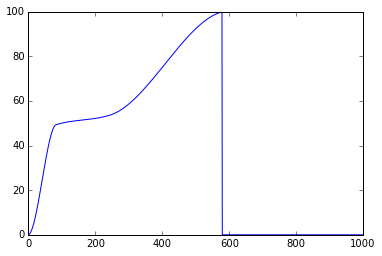

In [105]:
plt.plot(arr0[0,:])
plt.show()

In [ ]:
np.histogram2d(

In [107]:
plt.hist2d(arr)

plt.show()

TypeError: hist2d() missing 1 required positional argument: 'y'

In [111]:
import numba as nb
from numba import jit

In [ ]:
nb.jit(